In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu VPB và chia dataset theo tỉ lệ 8:1:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/VPB.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

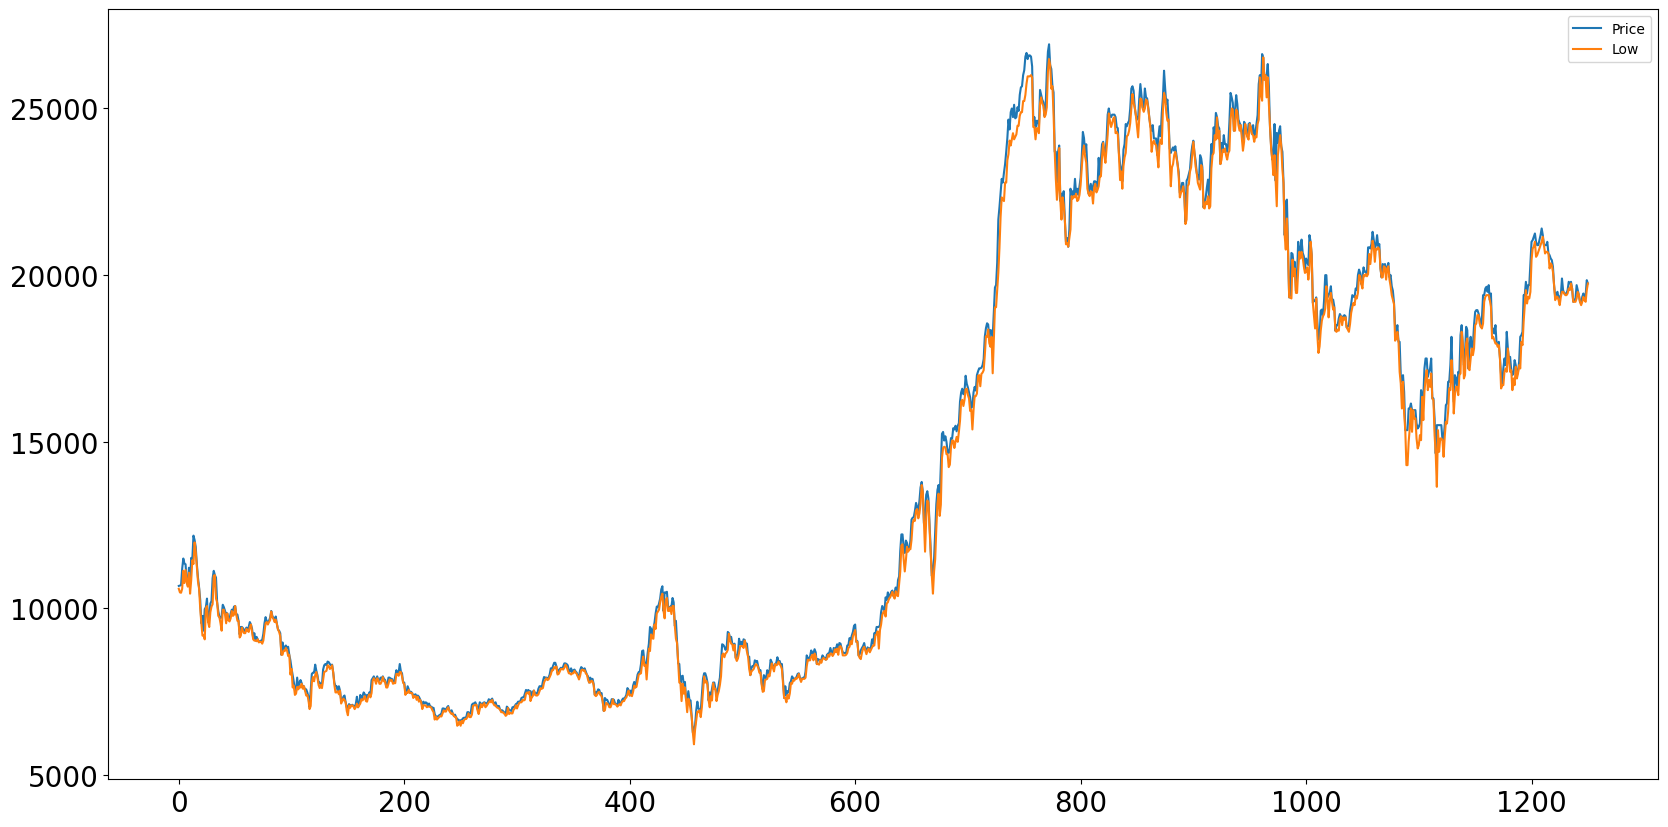

In [ ]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [ ]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.0092114971561106,
 0.7498898098466933,
 23,
 1227,
 {'1%': -3.435690695421723,
  '5%': -2.863898416697677,
  '10%': -2.5680256555204184},
 17822.00618770349)

In [ ]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [ ]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-6.764614757025684,
 2.7371502262804035e-09,
 22,
 1227,
 {'1%': -3.435690695421723,
  '5%': -2.863898416697677,
  '10%': -2.5680256555204184},
 17807.55746247881)

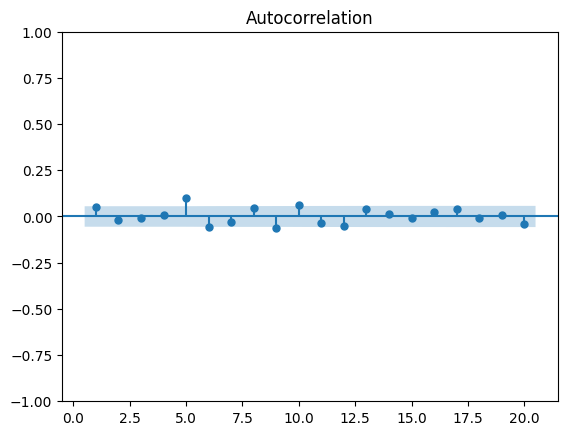

In [ ]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df

,Price,Low
0,10676.9,10590.4
1,10687.7,10482.4
2,10698.5,10471.6
3,11195.6,10590.4
4,11498.2,11130.8
...,...,...
1246,19450.0,19350.0
1247,19300.0,19250.0
1248,19400.0,19200.0
1249,19850.0,19550.0


In [ ]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=14452.212, Time=6.69 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14472.215, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14460.884, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14462.473, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14471.005, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=14467.722, Time=2.03 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=14466.297, Time=1.60 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=14455.870, Time=14.47 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=14455.800, Time=13.44 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=14463.739, Time=2.87 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=14452.263, Time=7.78 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=14452.334, Time=3.99 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=inf, Time=8.65 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=14464.053, Time=1.40 sec
 ARIMA(2,1,1)(1,0,1)[5]

**Dùng SARIMAX để train model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(2,1,4), seasonal_order=(0, 0, 0, 5))
model_fit = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([20100. , 20233.3, 19866.7, 20166.7, 21000. , 20600. , 19166.7,
       18800. , 18400. , 19300. , 18200. , 17666.7, 17866.7, 18333.3,
       18633.3, 18766.7, 18833.3, 19000. , 19666.7, 19333.3, 18733.3,
       19233.3, 19466.7, 19200. , 18966.7, 19033.3, 18333.3, 18300. ,
       18366.7, 18333.3, 18700. , 18766.7, 18500. , 18733.3, 18666.7,
       18733.3, 18433.3, 18366.7, 18300. , 18533.3, 18866.7, 19033.3,
       19166.7, 19100. , 19366.7, 19300. , 19466.7, 20000. , 19966.7,
       19733.3, 19600. , 20000. , 19966.7, 20033.3, 19966.7, 20033.3,
       20633.3, 20333.3, 20700. , 21033.3, 20866.7, 20400. , 20800. ,
       20766.7, 20833.3, 20766.7, 20200. , 19933.3, 19933.3, 20266.7,
       20233.3, 19866.7, 20200. , 20266.7, 19866.7, 19666.7, 19400. ,
       19266.7, 19133.3, 18033.3, 18100. , 18300. , 18000. , 17100. ,
       16750. , 16000. , 16800. , 15850. , 15350. , 14300. , 14300. ,
       15000. , 15400. , 16000. , 15300. , 15950. , 15700. , 15700. ,
       15100. , 1480

**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
last_index = df.index[-1]
exg = np.array(val_data['Low'])
y_pred_val = model_fit.predict(start=len(x_train), end = len(x_train)+ len(y_val)-1, exog=exg)
y_pred_val

array([15550., 15900., 16600., 16550., 17450., 16900., 15850., 16400.,
       16650., 16650., 16400., 17000., 17050., 18300., 17950., 16900.,
       17000., 17950., 18100., 17200., 17150., 17500., 17800., 17600.,
       17800., 18500., 18550., 18800., 18800., 18550., 18450., 18400.,
       18550., 19200., 19350., 19400., 19400., 19400., 19250., 19050.,
       18100., 18150., 18050., 17950., 17950., 17850., 17900., 17500.,
       16600., 16700., 16700., 17100., 17200., 17100., 17800., 17450.,
       17100., 17150., 16550., 16900., 16700., 17250., 16900., 17050.,
       17300., 17200., 18000., 17900., 18600., 19100., 19550., 19150.,
       19350., 19300., 19500., 20450., 20800., 20850., 21000., 20550.,
       20600., 20700., 20800., 20900., 21000., 21150., 20900., 20650.,
       20700., 20700., 20650., 20200., 20350., 20300., 20100., 19700.,
       19250., 19350., 19350., 19250., 19100., 19350., 19500., 19500.,
       19450., 19400., 19400., 19450., 19600., 19550., 19750., 19600.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[27519.81279002 27539.22524097 27558.63769192 27578.05014287
 27597.46259382 27616.87504477 27636.28749572 27655.69994668
 27675.11239763 27694.52484858 27713.93729953 27733.34975048
 27752.76220143 27772.17465238 27791.58710334 27810.99955429
 27830.41200524 27849.82445619 27869.23690714 27888.64935809
 27908.06180904 27927.47426    27946.88671095 27966.2991619
 27985.71161285 28005.1240638  28024.53651475 28043.9489657
 28063.36141666 28082.77386761]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 372.8376811803449
Testing RMSE: 452.42900083880556
Validation MAPE: 1.427321954331313
Testing MAPE: 1.8250902085471303
Validation MAE: 265.87301587301585
Testing MAE: 322.9328


**8. Vẽ biểu đồ**

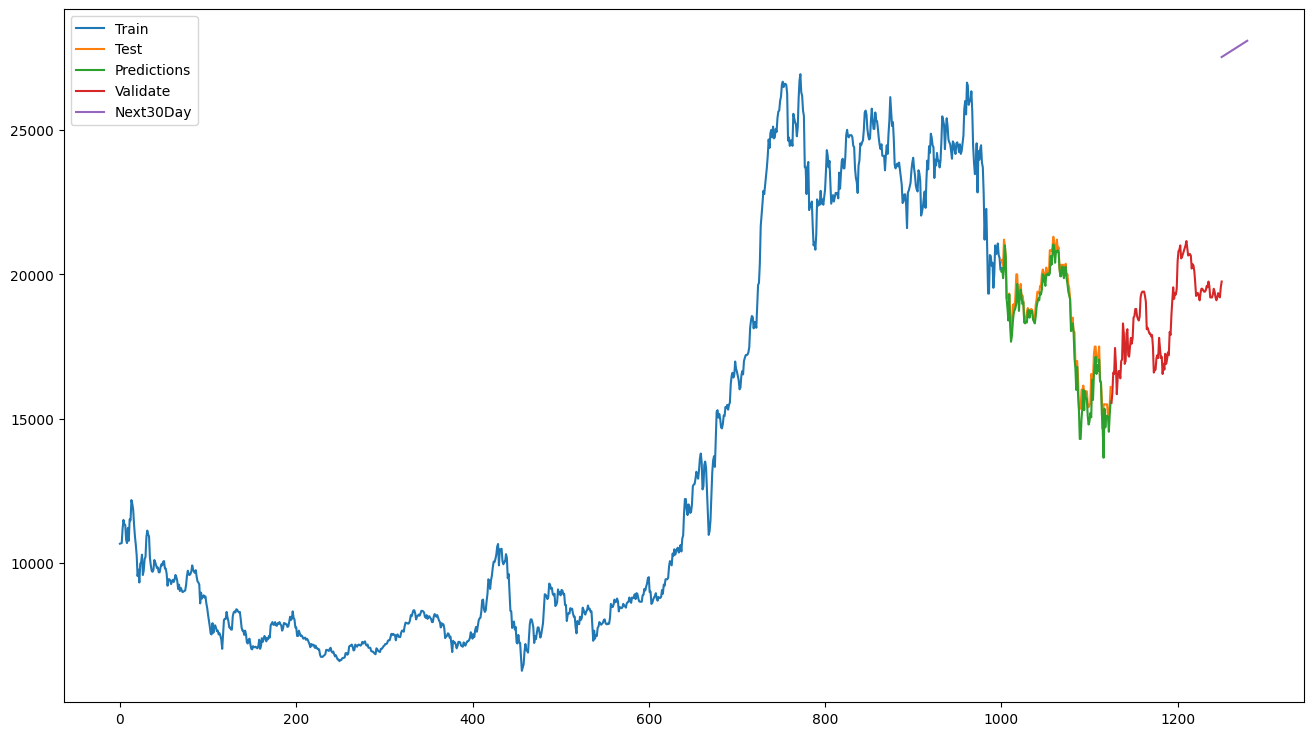

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()